# NLP Analysis of Clinical Notes for Sepsis Detection and Insights

This notebook utilizes PyTorch, NLTK, spaCy to perform Named Entity Recognition (NER), to analyze sentiment, to conduct topic modeling and to extract relationships within a clinical notes dataset, with sepsis as the central diagnosis.

### Installation and Imports

In [1]:
!pip install -q spacy transformers

import spacy
import torch

!python -m spacy download en_core_web_sm

# Check GPU availability
if torch.cuda.is_available():
    print("GPU is available and will be used for processing.")
else:
    print("GPU is not available. The CPU will be used for processing.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
GPU is not available. The CPU will be used for processing.


### Load datasets

In [2]:
import os
import pandas as pd

# Set up the directory path
directory = os.getenv('CLINICAL_REFS_DIR', "./clinical_refs")

if not os.path.exists(directory):
    os.makedirs(directory)

# File paths
train_file_path = os.path.join(directory, 'MTS-Dialog-TrainingSet.csv')
validation_file_path = os.path.join(directory, 'MTS-Dialog-ValidationSet.csv')

# Load the datasets
train_df = pd.read_csv(train_file_path)
validation_df = pd.read_csv(validation_file_path)

# Explicitly retrieve headers
train_headers = train_df.columns.tolist()
validation_headers = validation_df.columns.tolist()

# Print the column headers to confirm the available columns
print("Training dataset columns:", train_headers)
print("Validation dataset columns:", validation_headers)

# Display the first few rows of each dataset
print("Training dataset preview:")
print(train_df.head())

print("Validation dataset preview:")
print(validation_df.head())


Training dataset columns: ['ID', 'section_header', 'section_text', 'dialogue']
Validation dataset columns: ['ID', 'section_header', 'section_text', 'dialogue']
Training dataset preview:
   ID section_header                                       section_text  \
0   0          GENHX  The patient is a 76-year-old white female who ...   
1   1          GENHX  The patient is a 25-year-old right-handed Cauc...   
2   2          GENHX  This is a 22-year-old female, who presented to...   
3   3    MEDICATIONS  Prescribed medications were Salmeterol inhaler...   
4   4             CC                                   Burn, right arm.   

                                            dialogue  
0  Doctor: What brings you back into the clinic t...  
1  Doctor: How're you feeling today?  \r\nPatient...  
2  Doctor: Hello, miss. What is the reason for yo...  
3  Doctor: Are you taking any over the counter me...  
4  Doctor: Hi, how are you? \r\nPatient: I burned...  
Validation dataset preview:
   ID

## Preprocess notes

In [3]:
import pandas as pd
import re
import os
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')

def preprocess_text(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A).lower()
    # Tokenize the text
    tokens = text.split()
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Adjust display settings
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Set up the directory path
directory = os.getenv('CLINICAL_REFS_DIR', "./clinical_refs")

if not os.path.exists(directory):
    os.makedirs(directory)

# File paths
train_file_path = os.path.join(directory, 'MTS-Dialog-TrainingSet.csv')
validation_file_path = os.path.join(directory, 'MTS-Dialog-ValidationSet.csv')

# Process each CSV file in the directory
dfs = []
try:
    files = [train_file_path, validation_file_path]
    for file_path in files:
        print(f"Reading file: {file_path}")
        df = pd.read_csv(file_path)
        print(f"Columns in {file_path}: {df.columns.tolist()}")
        # Check if 'section_text' column exists
        if 'section_text' in df.columns:
            df['section_text_clean'] = df['section_text'].apply(preprocess_text)
            dfs.append(df)
            print(f"Processed file: {file_path}")
        else:
            print(f"Column 'section_text' not found in file: {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

# Display the first few rows of each dataset after preprocessing
if dfs:
    train_df = dfs[0]
    validation_df = dfs[1]

    print("Training dataset preview:")
    print(train_df[['section_text', 'section_text_clean']].head())

    print("Validation dataset preview:")
    print(validation_df[['section_text', 'section_text_clean']].head())
else:
    print("No CSV files were processed.")



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Reading file: ./clinical_refs/MTS-Dialog-TrainingSet.csv
Columns in ./clinical_refs/MTS-Dialog-TrainingSet.csv: ['ID', 'section_header', 'section_text', 'dialogue']
Processed file: ./clinical_refs/MTS-Dialog-TrainingSet.csv
Reading file: ./clinical_refs/MTS-Dialog-ValidationSet.csv
Columns in ./clinical_refs/MTS-Dialog-ValidationSet.csv: ['ID', 'section_header', 'section_text', 'dialogue']
Processed file: ./clinical_refs/MTS-Dialog-ValidationSet.csv
Training dataset preview:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

###  Named Entity Recognition (NER) 

In [4]:
import spacy

# Load the spaCy model for NER with error handling
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    from spacy.cli import download
    download('en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

def perform_ner(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply NER to the training dataset
train_df['entities'] = train_df['section_text_clean'].apply(perform_ner)
print("NER performed on the training dataset.")

# Apply NER to the validation dataset
validation_df['entities'] = validation_df['section_text_clean'].apply(perform_ner)
print("NER performed on the validation dataset.")

# Display the first few rows of each dataset after NER
print("Training dataset after NER:")
print(train_df[['section_text_clean', 'entities']].head())

print("Validation dataset after NER:")
print(validation_df[['section_text_clean', 'entities']].head())


NER performed on the training dataset.
NER performed on the validation dataset.
Training dataset after NER:
                                                                                                                                                                                                                                                                                                                                                                                                                                                            section_text_clean  \
0                                                                                                                                                                patient yearold white female presents clinic today originally hypertension med check history hypertension osteoarthritis osteoporosis hypothyroidism allergic rhinitis kidney stones since last visit followed dr kumar issues stable fever chills cough congestion nause

### Sentiment Analysis

In [5]:
from transformers import pipeline, AutoTokenizer

# Load the sentiment analysis pipeline with a specified model
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
sentiment_analyzer = pipeline('sentiment-analysis', model=model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def truncate_text(text, tokenizer, max_length=512):
    # Use tokenizer to encode the text and ensure truncation
    inputs = tokenizer(text, max_length=max_length, truncation=True, return_tensors='pt')
    # Decode back to string to verify truncation
    truncated_text = tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)
    return truncated_text

# Define a function to analyze sentiment
def analyze_sentiment(text):
    truncated_text = truncate_text(text, tokenizer)
    result = sentiment_analyzer(truncated_text)[0]
    return result['label'], result['score']

# Apply sentiment analysis to the training dataset
train_df['sentiment'] = train_df['section_text_clean'].apply(lambda x: analyze_sentiment(x))
print("Sentiment analysis performed on the training dataset.")

# Apply sentiment analysis to the validation dataset
validation_df['sentiment'] = validation_df['section_text_clean'].apply(lambda x: analyze_sentiment(x))
print("Sentiment analysis performed on the validation dataset.")

# Display the first few rows of each dataset after sentiment analysis
print("Training dataset after sentiment analysis:")
print(train_df[['section_text_clean', 'sentiment']].head())

print("Validation dataset after sentiment analysis:")
print(validation_df[['section_text_clean', 'sentiment']].head())


/home/codespace/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/codespace/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
/home/codespace/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=T

Sentiment analysis performed on the training dataset.
Sentiment analysis performed on the validation dataset.
Training dataset after sentiment analysis:
                                                                                                                                                                                                                                                                                                                                                                                                                                                            section_text_clean  \
0                                                                                                                                                                patient yearold white female presents clinic today originally hypertension med check history hypertension osteoarthritis osteoporosis hypothyroidism allergic rhinitis kidney stones since last visit followed dr kumar issu

### Relation Extraction

In [6]:
import spacy
from spacy.tokens import Span
from spacy.matcher import Matcher

# Load the spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    from spacy.cli import download
    download('en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

def extract_relations(doc):
    # Define the pattern for relation extraction
    pattern = [{'DEP': 'nsubj'}, {'DEP': 'ROOT'}, {'DEP': 'dobj'}]
    
    # Initialize the matcher with the pattern
    matcher = Matcher(nlp.vocab)
    matcher.add('relation_pattern', [pattern])
    
    # Apply the matcher to the doc
    matches = matcher(doc)
    relations = []
    
    for match_id, start, end in matches:
        span = doc[start:end]
        relations.append((span.text, span.root.head.text))
    
    return relations

# Apply relation extraction to the training dataset
train_df['relations'] = train_df['section_text_clean'].apply(lambda x: extract_relations(nlp(x)))
print("Relation extraction performed on the training dataset.")

# Apply relation extraction to the validation dataset
validation_df['relations'] = validation_df['section_text_clean'].apply(lambda x: extract_relations(nlp(x)))
print("Relation extraction performed on the validation dataset.")

# Display the first few rows of each dataset after relation extraction
print("Training dataset after relation extraction:")
print(train_df[['section_text_clean', 'relations']].head())

print("Validation dataset after relation extraction:")
print(validation_df[['section_text_clean', 'relations']].head())


Relation extraction performed on the training dataset.
Relation extraction performed on the validation dataset.
Training dataset after relation extraction:
                                                                                                                                                                                                                                                                                                                                                                                                                                                            section_text_clean  \
0                                                                                                                                                                patient yearold white female presents clinic today originally hypertension med check history hypertension osteoarthritis osteoporosis hypothyroidism allergic rhinitis kidney stones since last visit followed dr kumar i

In [7]:
import spacy
from spacy.tokens import Span

# Load the spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    from spacy.cli import download
    download('en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

def extract_relations(doc):
    relations = []
    for token in doc:
        if token.dep_ in ('nsubj', 'dobj'):
            subject = [w for w in token.head.lefts if w.dep_ == 'nsubj']
            if subject:
                subject = subject[0]
                relation = (subject.text, token.head.text, token.text)
                relations.append(relation)
    return relations

# Apply relation extraction to the training dataset
train_df['relations'] = train_df['section_text_clean'].apply(lambda x: extract_relations(nlp(x)))
print("Relation extraction performed on the training dataset.")

# Apply relation extraction to the validation dataset
validation_df['relations'] = validation_df['section_text_clean'].apply(lambda x: extract_relations(nlp(x)))
print("Relation extraction performed on the validation dataset.")

# Display the first few rows of each dataset after relation extraction
print("Training dataset after relation extraction:")
print(train_df[['section_text_clean', 'relations']].head())

print("Validation dataset after relation extraction:")
print(validation_df[['section_text_clean', 'relations']].head())


Relation extraction performed on the training dataset.
Relation extraction performed on the validation dataset.
Training dataset after relation extraction:
                                                                                                                                                                                                                                                                                                                                                                                                                                                            section_text_clean  \
0                                                                                                                                                                patient yearold white female presents clinic today originally hypertension med check history hypertension osteoarthritis osteoporosis hypothyroidism allergic rhinitis kidney stones since last visit followed dr kumar i

### Topic Modeling

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Define the number of topics
num_topics = 5

def perform_topic_modeling(data):
    # Vectorize the text data
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    X = vectorizer.fit_transform(data['section_text_clean'])

    # Apply LDA for topic modeling
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)

    # Display the top words for each topic
    def display_topics(model, feature_names, num_top_words):
        for topic_idx, topic in enumerate(model.components_):
            print(f"Topic {topic_idx}:")
            print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

    # Display the topics
    num_top_words = 10
    display_topics(lda, vectorizer.get_feature_names_out(), num_top_words)

# Apply topic modeling to the training dataset
print("Training dataset topics:")
perform_topic_modeling(train_df)

# Apply topic modeling to the validation dataset
print("Validation dataset topics:")
perform_topic_modeling(validation_df)


Training dataset topics:
Topic 0:
use drug patient alcohol history denies lives married allergies years
Topic 1:
patient home history sleep nonsmoker yearold months post medications status
Topic 2:
died history mother age father disease diabetes family cancer surgery
Topic 3:
patient pain states right yearold left time denies symptoms history
Topic 4:
negative history pain patient chest today past denies left noncontributory
Validation dataset topics:
Topic 0:
pain right extremity weakness neck left symptoms denies yearold upper
Topic 1:
patient pain right past significant yearold changes mg like states
Topic 2:
lost dr headache medications followup dermatitis atopic home psychiatric left
Topic 3:
patient denies pain history abuse time nausea symptoms past alcohol
Topic 4:
age died disease hypertension history surgery negative cancer old father


In [9]:
!pip install gensim

import nltk
nltk.download('punkt')

import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def prepare_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

def perform_topic_modeling_gensim(df):
    # Tokenize the text
    df['tokens'] = df['section_text_clean'].apply(prepare_text)

    # Create Dictionary and Corpus needed for Topic Modeling
    id2word = corpora.Dictionary(df['tokens'])
    texts = df['tokens']
    corpus = [id2word.doc2bow(text) for text in texts]

    # Build the LDA model
    lda_model = LdaModel(
        corpus=corpus, 
        id2word=id2word, 
        num_topics=5, 
        random_state=42, 
        update_every=1, 
        chunksize=100, 
        passes=10, 
        alpha='auto', 
        per_word_topics=True
    )

    # Extract the topics
    topics = lda_model.print_topics(num_words=5)

    # Display the topics
    for topic in topics:
        print(topic)

# Apply topic modeling to the training dataset
print("Training dataset topics:")
perform_topic_modeling_gensim(train_df)

# Apply topic modeling to the validation dataset
print("Validation dataset topics:")
perform_topic_modeling_gensim(validation_df)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Training dataset topics:
(0, '0.025*"age" + 0.016*"treatment" + 0.012*"loss" + 0.011*"noncontributory" + 0.010*"post"')
(1, '0.032*"patient" + 0.029*"currently" + 0.028*"daily" + 0.028*"smoke" + 0.027*"previously"')
(2, '0.054*"lives" + 0.049*"nursing" + 0.047*"security" + 0.047*"citizens" + 0.047*"building"')
(3, '0.022*"history" + 0.014*"significant" + 0.011*"dr" + 0.011*"hypertension" + 0.011*"cancer"')
(4, '0.039*"pain" + 0.026*"patient" + 0.015*"right" + 0.014*"left" + 0.012*"back"')
Validation dataset topics:
(0, '0.023*"denies" + 0.015*"pain" + 0.011*"patient" + 0.009*"symptoms" + 0.009*"negative"')
(1, '0.016*"patient" + 0.009*"lost" + 0.007*"well" + 0.007*"dr" + 0.007*"feeling"')
(2, '0.027*"pain" + 0.013*"right" + 0.012*"states" + 0.010*"symptoms" + 0.009*"surgery"')
(3, '0.028*"age" + 0.023*"died" + 0.016*"patient" + 0.015*"cancer" + 0.015*"disease"')
(4, '0.031*"pain" + 0.020*"patient" + 0.018*"history" + 0.011*"left" + 0.011*"denies"')


Symptom-Related Clinical Insights for Training Dataset related to sepsis, infection, treatment, symptoms, diagnosis:

Most Common Entities Related to Symptoms of Sepsis:
today: 39
daily: 11
anesthesia: 9
morning: 8
night: 7
days: 6
years: 6
abc: 6
first: 5
one year: 5

Sentiment Distribution Related to Symptoms of Sepsis:
NEGATIVE: 129
POSITIVE: 3

Most Common Relations Related to Symptoms of Sepsis:
questions-answered-questions: 10
surgery-include-surgery: 6
parents-agreed-parents: 6
failure-need-failure: 6
patient-denies-patient: 5
pain-described-pain: 5
symptoms-resolved-symptoms: 4
patient-received-patient: 4
female-comes-female: 4
allergies-diminished-allergies: 4


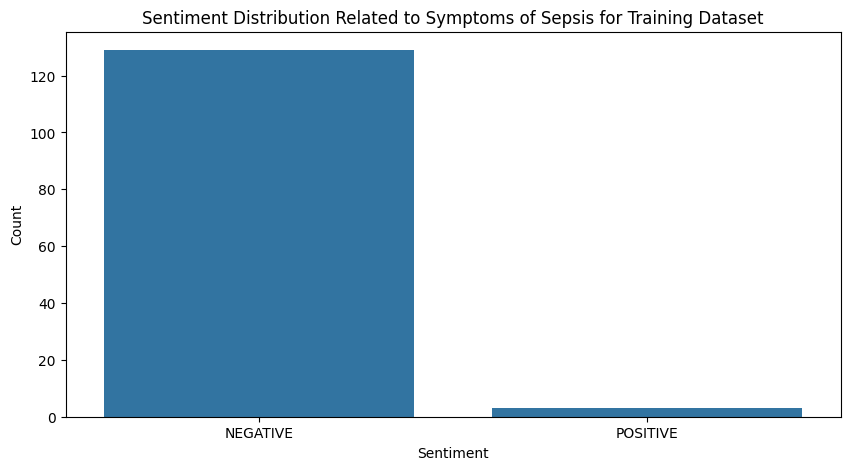


Top Topics Related to Symptoms of Sepsis:
(0, '0.013*"patient" + 0.013*"pain" + 0.013*"history" + 0.011*"treatment" + 0.010*"left"')
(1, '0.028*"patient" + 0.014*"left" + 0.011*"hand" + 0.010*"symptoms" + 0.010*"right"')
(2, '0.020*"patient" + 0.012*"surgery" + 0.010*"risks" + 0.008*"symptoms" + 0.007*"left"')
(3, '0.045*"pain" + 0.024*"patient" + 0.015*"back" + 0.011*"symptoms" + 0.009*"left"')
(4, '0.010*"methadone" + 0.009*"history" + 0.007*"help" + 0.007*"symptoms" + 0.006*"medications"')
Symptom-Related Clinical Insights for Validation Dataset related to sepsis, infection, treatment, symptoms, diagnosis:

Most Common Entities Related to Symptoms of Sepsis:
today: 5
second: 3
abc: 2
weeks: 2
two: 2
years: 2
eight years ago: 1
one two: 1
past eight years: 1
august: 1

Sentiment Distribution Related to Symptoms of Sepsis:
NEGATIVE: 11

Most Common Relations Related to Symptoms of Sepsis:
metoprolol-increased-metoprolol: 2
thumb-diagnosed-thumb: 2
symptoms-described-symptoms: 2
femal

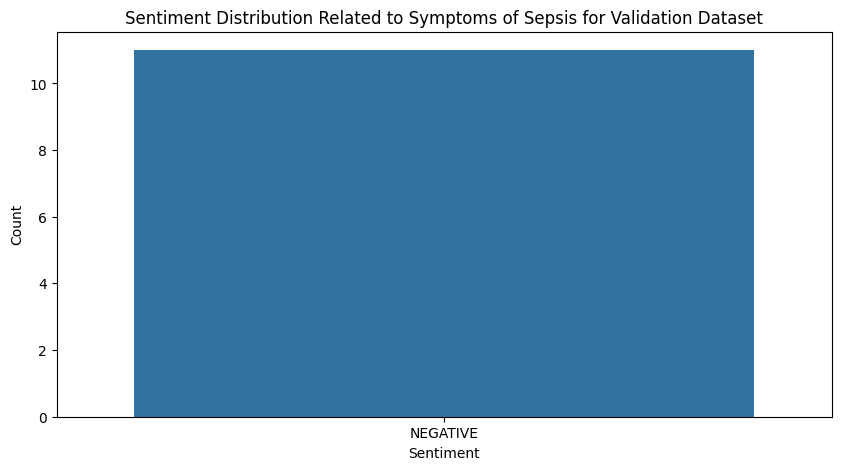


Top Topics Related to Symptoms of Sepsis:
(0, '0.029*"pain" + 0.017*"hands" + 0.013*"denies" + 0.013*"recently" + 0.009*"weeks"')
(1, '0.023*"position" + 0.016*"feeling" + 0.016*"stands" + 0.016*"lightheaded" + 0.016*"increased"')
(2, '0.048*"patient" + 0.028*"pain" + 0.021*"right" + 0.018*"stated" + 0.014*"deformity"')
(3, '0.051*"pain" + 0.033*"symptoms" + 0.022*"extremity" + 0.019*"weakness" + 0.019*"upper"')
(4, '0.015*"headache" + 0.015*"leftsided" + 0.011*"pain" + 0.011*"years" + 0.011*"degenerative"')


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Define sepsis-related keywords, including symptoms
sepsis_keywords = ["sepsis", "infection", "treatment", "symptoms", "diagnosis"]

def summarize_symptom_insights(df, title, keywords):
    print(f"Symptom-Related Clinical Insights for {title} related to {', '.join(keywords)}:")

    # Aggregate entities related to symptoms
    symptom_related_entities = []
    for entities, text in zip(df['entities'], df['section_text_clean']):
        if any(keyword.lower() in text.lower() for keyword in keywords):
            symptom_related_entities.extend([ent[0] for ent in entities])

    entity_counts = Counter(symptom_related_entities)
    common_entities = entity_counts.most_common(10)
    print("\nMost Common Entities Related to Symptoms of Sepsis:")
    for entity, count in common_entities:
        print(f"{entity}: {count}")

    # Aggregate sentiment related to symptoms
    symptom_related_sentiments = []
    for sentiment, text in zip(df['sentiment'], df['section_text_clean']):
        if any(keyword.lower() in text.lower() for keyword in keywords):
            symptom_related_sentiments.append(sentiment[0])

    sentiment_counts = Counter(symptom_related_sentiments)
    print("\nSentiment Distribution Related to Symptoms of Sepsis:")
    for sentiment, count in sentiment_counts.items():
        print(f"{sentiment}: {count}")

    # Aggregate relations related to symptoms
    symptom_related_relations = []
    for relations, text in zip(df['relations'], df['section_text_clean']):
        if any(keyword.lower() in text.lower() for keyword in keywords):
            symptom_related_relations.extend([f"{rel[0]}-{rel[1]}-{rel[2]}" for rel in relations])

    relation_counts = Counter(symptom_related_relations)
    common_relations = relation_counts.most_common(10)
    print("\nMost Common Relations Related to Symptoms of Sepsis:")
    for relation, count in common_relations:
        print(f"{relation}: {count}")

    # Display sentiment distribution as a bar chart
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(sentiment_counts.keys()), y=list(sentiment_counts.values()))
    plt.title(f"Sentiment Distribution Related to Symptoms of Sepsis for {title}")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

    # Display top topics related to symptoms
    print("\nTop Topics Related to Symptoms of Sepsis:")
    symptom_texts = df[df['section_text_clean'].str.contains('|'.join(keywords), case=False, na=False)]['tokens']
    id2word = corpora.Dictionary(symptom_texts)
    corpus = [id2word.doc2bow(text) for text in symptom_texts]
    lda_model = LdaModel(
        corpus=corpus, 
        id2word=id2word, 
        num_topics=5, 
        random_state=42, 
        update_every=1, 
        chunksize=100, 
        passes=10, 
        alpha='auto', 
        per_word_topics=True
    )
    topics = lda_model.print_topics(num_words=5)
    for topic in topics:
        print(topic)

# Summarize the key symptom-related insights for the training dataset
summarize_symptom_insights(train_df, "Training Dataset", sepsis_keywords)

# Summarize the key symptom-related insights for the validation dataset
summarize_symptom_insights(validation_df, "Validation Dataset", sepsis_keywords)


### Comparison: Validation and Training datasets

Comparative Analysis Between Training and Validation Datasets

Common Entities in Training Dataset:
today: 39
daily: 11
anesthesia: 9
morning: 8
night: 7
days: 6
years: 6
abc: 6
first: 5
one year: 5

Common Entities in Validation Dataset:
today: 5
second: 3
abc: 2
weeks: 2
two: 2
years: 2
eight years ago: 1
one two: 1
past eight years: 1
august: 1

Sentiment Distribution in Training Dataset:
NEGATIVE: 129
POSITIVE: 3

Sentiment Distribution in Validation Dataset:
NEGATIVE: 11


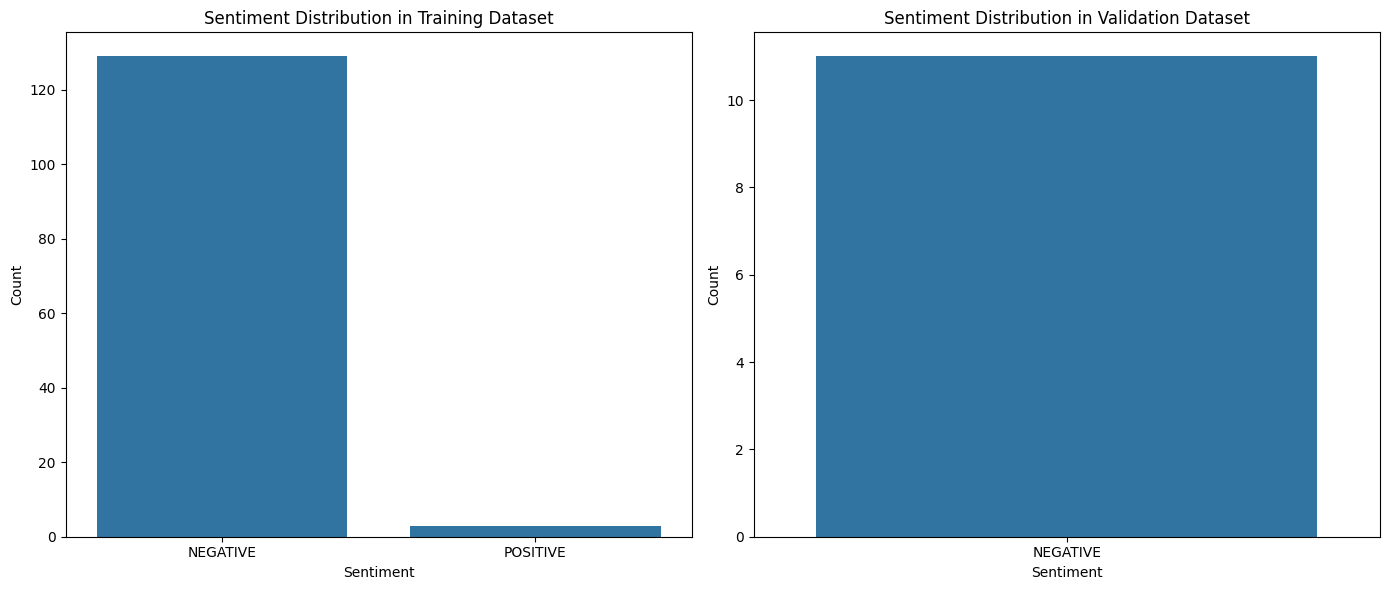


Common Relations in Training Dataset:
questions-answered-questions: 10
surgery-include-surgery: 6
parents-agreed-parents: 6
failure-need-failure: 6
patient-denies-patient: 5
pain-described-pain: 5
symptoms-resolved-symptoms: 4
patient-received-patient: 4
female-comes-female: 4
allergies-diminished-allergies: 4

Common Relations in Validation Dataset:
metoprolol-increased-metoprolol: 2
thumb-diagnosed-thumb: 2
symptoms-described-symptoms: 2
female-referred-female: 1
injury-occurred-injury: 1
patient-stated-patient: 1
visits-received-visits: 1
pack-stated-pack: 1
pack-stated-degrees: 1
patient-gave-patient: 1


In [17]:
def compare_datasets(train_df, val_df, keywords):
    print("Comparative Analysis Between Training and Validation Datasets")

    def get_common_entities(df, keywords):
        entities = []
        for ents, text in zip(df['entities'], df['section_text_clean']):
            if any(keyword.lower() in text.lower() for keyword in keywords):
                entities.extend([ent[0] for ent in ents])
        return Counter(entities).most_common(10)

    def get_sentiment_distribution(df, keywords):
        sentiments = []
        for sentiment, text in zip(df['sentiment'], df['section_text_clean']):
            if any(keyword.lower() in text.lower() for keyword in keywords):
                sentiments.append(sentiment[0])
        return Counter(sentiments)

    def get_common_relations(df, keywords):
        relations = []
        for rels, text in zip(df['relations'], df['section_text_clean']):
            if any(keyword.lower() in text.lower() for keyword in keywords):
                relations.extend([f"{rel[0]}-{rel[1]}-{rel[2]}" for rel in rels])
        return Counter(relations).most_common(10)

    # Compare common entities
    train_entities = get_common_entities(train_df, keywords)
    val_entities = get_common_entities(val_df, keywords)

    print("\nCommon Entities in Training Dataset:")
    for entity, count in train_entities:
        print(f"{entity}: {count}")

    print("\nCommon Entities in Validation Dataset:")
    for entity, count in val_entities:
        print(f"{entity}: {count}")

    # Compare sentiment distribution
    train_sentiments = get_sentiment_distribution(train_df, keywords)
    val_sentiments = get_sentiment_distribution(val_df, keywords)

    print("\nSentiment Distribution in Training Dataset:")
    for sentiment, count in train_sentiments.items():
        print(f"{sentiment}: {count}")

    print("\nSentiment Distribution in Validation Dataset:")
    for sentiment, count in val_sentiments.items():
        print(f"{sentiment}: {count}")

    # Plot sentiment distribution
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x=list(train_sentiments.keys()), y=list(train_sentiments.values()))
    plt.title("Sentiment Distribution in Training Dataset")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    sns.barplot(x=list(val_sentiments.keys()), y=list(val_sentiments.values()))
    plt.title("Sentiment Distribution in Validation Dataset")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

    # Compare common relations
    train_relations = get_common_relations(train_df, keywords)
    val_relations = get_common_relations(val_df, keywords)

    print("\nCommon Relations in Training Dataset:")
    for relation, count in train_relations:
        print(f"{relation}: {count}")

    print("\nCommon Relations in Validation Dataset:")
    for relation, count in val_relations:
        print(f"{relation}: {count}")

# Perform the comparative analysis between the training and validation datasets
compare_datasets(train_df, validation_df, sepsis_keywords)


Sepsis-Focused Clinical Insights for Training Dataset:

Most Common Entities Related to Sepsis:

Sentiment Distribution Related to Sepsis:
NEGATIVE: 2

Most Common Relations Related to Sepsis:


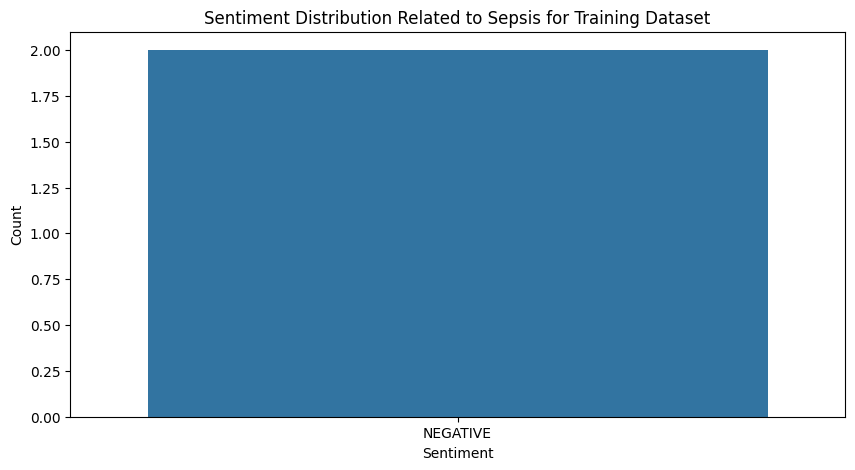


Top Topics Related to Sepsis:
(0, '0.261*"sbp" + 0.261*"possible" + 0.261*"sepsis" + 0.044*"pneumonia" + 0.044*"coagulation"')
(1, '0.125*"sepsis" + 0.125*"possible" + 0.125*"sbp" + 0.125*"pneumonia" + 0.125*"coagulation"')
(2, '0.125*"sepsis" + 0.125*"sbp" + 0.125*"possible" + 0.125*"intravascular" + 0.125*"disseminated"')
(3, '0.158*"sepsis" + 0.158*"coagulation" + 0.158*"streptococcal" + 0.158*"disseminated" + 0.158*"intravascular"')
(4, '0.125*"pneumonia" + 0.125*"intravascular" + 0.125*"disseminated" + 0.125*"sepsis" + 0.125*"streptococcal"')
Sepsis-Focused Clinical Insights for Validation Dataset:

Most Common Entities Related to Sepsis:

Sentiment Distribution Related to Sepsis:

Most Common Relations Related to Sepsis:


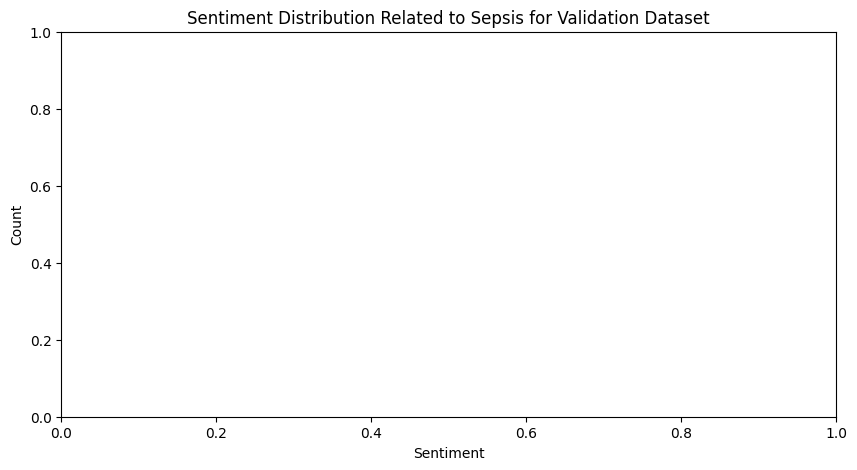


Top Topics Related to Sepsis:


ValueError: cannot compute LDA over an empty collection (no terms)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def summarize_sepsis_insights(df, title):
    sepsis_keyword = "sepsis"

    print(f"Sepsis-Focused Clinical Insights for {title}:")

    # Aggregate entities related to sepsis
    sepsis_entities = []
    for entities, text in zip(df['entities'], df['section_text_clean']):
        if sepsis_keyword in text.lower():
            sepsis_entities.extend([ent[0] for ent in entities])

    entity_counts = Counter(sepsis_entities)
    common_entities = entity_counts.most_common(10)
    print("\nMost Common Entities Related to Sepsis:")
    for entity, count in common_entities:
        print(f"{entity}: {count}")

    # Aggregate sentiment related to sepsis
    sepsis_sentiments = []
    for sentiment, text in zip(df['sentiment'], df['section_text_clean']):
        if sepsis_keyword in text.lower():
            sepsis_sentiments.append(sentiment[0])

    sentiment_counts = Counter(sepsis_sentiments)
    print("\nSentiment Distribution Related to Sepsis:")
    for sentiment, count in sentiment_counts.items():
        print(f"{sentiment}: {count}")

    # Aggregate relations related to sepsis
    sepsis_relations = []
    for relations, text in zip(df['relations'], df['section_text_clean']):
        if sepsis_keyword in text.lower():
            sepsis_relations.extend([f"{rel[0]}-{rel[1]}-{rel[2]}" for rel in relations])

    relation_counts = Counter(sepsis_relations)
    common_relations = relation_counts.most_common(10)
    print("\nMost Common Relations Related to Sepsis:")
    for relation, count in common_relations:
        print(f"{relation}: {count}")

    # Display sentiment distribution as a bar chart
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(sentiment_counts.keys()), y=list(sentiment_counts.values()))
    plt.title(f"Sentiment Distribution Related to Sepsis for {title}")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

    # Display top topics related to sepsis
    print("\nTop Topics Related to Sepsis:")
    sepsis_texts = df[df['section_text_clean'].str.contains(sepsis_keyword, case=False, na=False)]['tokens']
    id2word = corpora.Dictionary(sepsis_texts)
    corpus = [id2word.doc2bow(text) for text in sepsis_texts]
    lda_model = LdaModel(
        corpus=corpus, 
        id2word=id2word, 
        num_topics=5, 
        random_state=42, 
        update_every=1, 
        chunksize=100, 
        passes=10, 
        alpha='auto', 
        per_word_topics=True
    )
    topics = lda_model.print_topics(num_words=5)
    for topic in topics:
        print(topic)

# Summarize the key sepsis-related insights for the training dataset
summarize_sepsis_insights(train_df, "Training Dataset")

# Summarize the key sepsis-related insights for the validation dataset
summarize_sepsis_insights(validation_df, "Validation Dataset")

# Perform comparative analysis between training and validation datasets
def compare_datasets(train_df, val_df, keyword):
    print("Comparative Analysis Between Training and Validation Datasets Related to Sepsis")

    def get_common_entities(df, keyword):
        entities = []
        for ents, text in zip(df['entities'], df['section_text_clean']):
            if keyword.lower() in text.lower():
                entities.extend([ent[0] for ent in ents])
        return Counter(entities).most_common(10)

    def get_sentiment_distribution(df, keyword):
        sentiments = []
        for sentiment, text in zip(df['sentiment'], df['section_text_clean']):
            if keyword.lower() in text.lower():
                sentiments.append(sentiment[0])
        return Counter(sentiments)

    def get_common_relations(df, keyword):
        relations = []
        for rels, text in zip(df['relations'], df['section_text_clean']):
            if keyword.lower() in text.lower():
                relations.extend([f"{rel[0]}-{rel[1]}-{rel[2]}" for rel in rels])
        return Counter(relations).most_common(10)

    # Compare common entities
    train_entities = get_common_entities(train_df, keyword)
    val_entities = get_common_entities(val_df, keyword)

    print("\nCommon Entities in Training Dataset:")
    for entity, count in train_entities:
        print(f"{entity}: {count}")

    print("\nCommon Entities in Validation Dataset:")
    for entity, count in val_entities:
        print(f"{entity}: {count}")

    # Compare sentiment distribution
    train_sentiments = get_sentiment_distribution(train_df, keyword)
    val_sentiments = get_sentiment_distribution(val_df, keyword)

    print("\nSentiment Distribution in Training Dataset:")
    for sentiment, count in train_sentiments.items():
        print(f"{sentiment}: {count}")

    print("\nSentiment Distribution in Validation Dataset:")
    for sentiment, count in val_sentiments.items():
        print(f"{sentiment}: {count}")

    # Plot sentiment distribution
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x=list(train_sentiments.keys()), y=list(train_sentiments.values()))
    plt.title("Sentiment Distribution in Training Dataset")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    sns.barplot(x=list(val_sentiments.keys()), y=list(val_sentiments.values()))
    plt.title("Sentiment Distribution in Validation Dataset")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

    # Compare common relations
    train_relations = get_common_relations(train_df, keyword)
    val_relations = get_common_relations(val_df, keyword)

    print("\nCommon Relations in Training Dataset:")
    for relation, count in train_relations:
        print(f"{relation}: {count}")

    print("\nCommon Relations in Validation Dataset:")
    for relation, count in val_relations:
        print(f"{relation}: {count}")

# Perform the comparative analysis between the training and validation datasets related to sepsis
compare_datasets(train_df, validation_df, "sepsis")
